# 5.2 합성곱 신경망 맛보기

fashion_mnist 데이터셋을 사용하여 합성곱 신경망을 직접 구현한다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # ------ 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

이번 예제에서 사용할 fashion_mnist 데이터셋은 토치비전으로 내려받을 수 있다.

In [5]:
# 5-3 fashion_mnist 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()])) # No.1
test_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True,
                                                 train=False, transform=transforms.Compose([transforms.ToTensor()])) # 앞에서 훈련 데이터셋을 내려받았다면 여기에서는 테스트 데이터셋을 내려받는다.

#### No.1 
torchvision.datasets는 torch.utils.data.Dataset의 하위 클래스로 다양한 데이터셋을 포함한다.  
주요한 파라미터는 다음과 같다.  

첫 번째 파라미터 : FashionMnist를 내려받을 위치를 지정한다.  
download: download를 True로 벼경해주면 첫 번째 파라미터의 위리에 해당 데이터셋이 있는지 확인한 후 내려받는다.  
transform: 이미지를 텐서(0~1)로 변경한다.

In [6]:
# 코드 5-4 fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100) # ------ ①
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)


#### No.1
torch.utils.data.DataLoader()를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나, 순서가 무작위로 섞이도록 할 수 있다.  
데이터로더에서 사용하는 파라미터는 다음과 같다.  

첫 번째 파라미터: 데이터를 불러올 데이터셋을 지정한다.  
batch_size: 데이터를 배치로 묶어 준다. 여기에서는 100개 단위로 데이터를 묶어서 불러온다.  

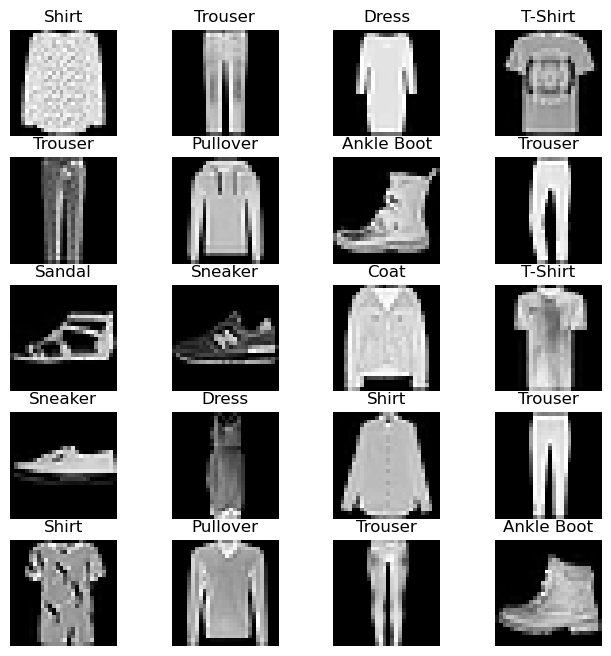

In [7]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'} # ------ 열 개의 클래스

fig = plt.figure(figsize=(8,8)); #  ------ 출력할 이미지의 가로세로 길이로 단위는 inch
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));  # No.1
    img = train_dataset[img_xy][0][0,:,:] # No.2
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show() # ------ 20개의 이미지 데이터를 시각적으로 표현

#### No.1
np.random은 무작위로 데이터를 생성할 때 사용한다.  
또한 np.random.randint()는 이산형 분포를 갖는 데이터에서 무작위 표본을 추출할 때 사용한다.  
따라서 random.randint(len(train_dataset))의 의미는 0~(train_dataset의 길이)값을 갖는 분포에서 랜덤한 숫자 한개를 생성하라는 의미이다.  
radnom.randint와 유사하게 사용되는 radnom.rand와 radndom.randn을 예시로 살펴본다.

In [6]:
import numpy as np
np.random.randint(10) # 0~10의 임의의 숫자를 출력

9

In [7]:
np.random.randint(1,10) # 1~9의 임의의 숫자를 출력

3

In [8]:
np.random.rand(8) # 0~1사이의 정규표준분포 난수를 행렬 (1x8) 출력

array([0.74990212, 0.33265276, 0.10066955, 0.98495776, 0.45686778,
       0.43063301, 0.84279921, 0.80191705])

In [9]:
np.random.rand(4,2) # 0~1 사이의 정규표준분포 난수를 행렬로 (4x2) 출력

array([[0.05992129, 0.96376266],
       [0.2911437 , 0.12723718],
       [0.60613004, 0.9372338 ],
       [0.02403201, 0.94011263]])

In [10]:
np.random.randn(8) # 평균이 0이고, 표준편차가 1인 가우시안 정규분포 난수를 행렬로(1x8)로 출력

array([ 0.29363462, -0.63038859,  0.2846512 ,  0.55568051,  0.10972292,
        2.49502365,  0.98350427,  1.14041546])

In [11]:
np.random.randn(4,2) # 평균이 0이고, 표준편차가 1인 가우시안 정규분포 난수를 행렬로(4x2)로 출력

array([[-1.14979017,  0.56372767],
       [-0.66897778,  0.58053703],
       [ 0.77835263, -1.76450552],
       [ 1.56881631, -0.90783306]])

#### No.2 
train_dataset을 이용한 3차원 배열을 생성한다.  
배열에 대한 사용은 다음 예시를 참고.

In [12]:
import numpy as np
examp = np.arange(0, 100, 3) # 1~99의 숫자에서 3씩 건너뛴 행려를 생성
examp.resize(6,4) # 행렬의 크기를 6x4로 수정
print(examp)
print(examp[3]) # 3행에 해당하는 모든 요소(값)들을 출력 (행과 열은 0부터 시작)
print(examp[3,3]) # 3행의 3번째 열에 대한 값을 출력
print(examp[3][3]) #위와 동일

[[ 0  3  6  9]
 [12 15 18 21]
 [24 27 30 33]
 [36 39 42 45]
 [48 51 54 57]
 [60 63 66 69]]
[36 39 42 45]
45
45


In [13]:
# 따라서 train_dataset[img_xy][0][0,:,:]의 의미는 다음 예시로 출력 결과를 유추해 볼 수 있다.
examp = np.arange(0, 500, 3)
examp.resize(3,5,5)
examp

array([[[  0,   3,   6,   9,  12],
        [ 15,  18,  21,  24,  27],
        [ 30,  33,  36,  39,  42],
        [ 45,  48,  51,  54,  57],
        [ 60,  63,  66,  69,  72]],

       [[ 75,  78,  81,  84,  87],
        [ 90,  93,  96,  99, 102],
        [105, 108, 111, 114, 117],
        [120, 123, 126, 129, 132],
        [135, 138, 141, 144, 147]],

       [[150, 153, 156, 159, 162],
        [165, 168, 171, 174, 177],
        [180, 183, 186, 189, 192],
        [195, 198, 201, 204, 207],
        [210, 213, 216, 219, 222]]])

In [14]:
examp[2][0][3]

159

합성곱 신경망과 합성곱 신경망이 아닌 심층 신경망의 비교를 위해 먼저 심층 신경망을 생성한 후 학습시켜본다.  
즉, ConvNet이 적용되지 않은 네트워크를 먼저 만들어본다.

In [8]:
# 5-6 심층신경망 모델 생성
class FashionDNN(nn.Module):
    def __init__(self): #No.1
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256) # No.2
        self.drop = nn.Dropout(0.25) # No.3
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data): # No.4
        out = input_data.view(-1, 784) # No.5
        out = F.relu(self.fc1(out)) # No.6
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


#### No.1
클래서(class)형태의 모델은 항상 torch.nn.Module을 상속 받는다.  
__init__()은 객체가 갖는 속성 값을 초기화 하는 역할을 하며, 객체가 생성될 때 자동으로 호출된다.  
super(FashionDNN, self).__init__()은 FashionDNN이라는 부모(super)클래스를 상속받겠다는 의미이다.  

#### No.2
nn은 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여있는 패키지이며, Linear는 단순 선형 회귀 모델을 만들 때 사용한다. 파라미터는 다음과 같다.
* in_features: 입력의 크기
* out_features: 출력의 크기
실제로 연산이 진행되는 forward() 부분에서는 첫 번째 파라미터 값만 넘겨주게 되며, 두 번째 파라미터에서 정의된 크기가 forward()연산의 결과가 된다.  

#### No.3
torch.nn.Dropout(p)는 p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커진다.  
예를들어 p=0.3이라는 의미는 전체 값중 0.3의 확률로 0이 된다는 것이며, 0이 되지않는 0.7에 해당하는 값은 (1/(1-0.7))만큼 커진다.

#### No.4
forward() 함수는 모델이 학습 데이터를 입력받아서 순전파(forward propagation) 학습을 진행시키며, 반드시 forward라는 이름의 함수여야 한다.  
즉, forward()는 모델이 학습 데이터를 입력받아서 순전파 연산을 진행하는 함수이며, 객체를 데이터와 함께 호출하면 자동으로 실행된다.  
이때 순전파 연산이란 H(x)^2식에 입력 x로부터 예측된 y를 얻는 것 이다.

#### No.5
파이토치에서 사용하는 뷰(view)는 넘파이의 reshape과 같은 역할로 텐서의 크기를 변경해주는 역할을 한다.  
따라서 input_data.view(-1, 784)는 input_data를 (?, 784)의 크기로 변경하라는 의미이다.  다시 말해서 2차원의 텐서로 변경하되, (?,784)의 크기로 변경하라는 의미이다.  

#### No.6
활성화 함수를 지정할 때는 다음 두가지 방법이 가능하다.
* F.relu(): forward() 함수에서 정의
* nn.ReLU(): __init__() 함수에서 정의
활성화 함수 사용에 한정하여 이 둘 간의 차이는 간단히 사용하는 위치라고 정의한다.  
하지만 근본적으로는 nn.functional.xx()(혹은 F.xx())와 nn.xx()는 사용 방법에 차이가 있다.  
nn.Conv2d에서 input_channel과 output_channel을 사용해서 연산했다면, functional.conv2d는 입력(input)과 가중치(weight)를 직접 넣어준다.  
이때 직접 넣어준다는 의미는 가중치를 전달 해야할 때마다 가중치 값을 새로 정의해야함을 의미한다.  
다음은 nn.xx와 nn.functional.xx를 비교한 표이다.  
<img src="표5-1.jpg" width="800" height="400"/>

모델을 학습시키기 전에 손실 함수, 학습률, 옵티마이저에 대해 정의한다.

In [9]:
# 5-7 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = FashionDNN()

criterion = nn.CrossEntropyLoss() # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # No.1
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [17]:
# 5-8 모델 학습 및 성능평가
num_epochs = 5
count = 0
loss_list = [] # ------ ①
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader: # ------ ②
        images, labels = images.to(device), labels.to(device) # ------ ③

        train = Variable(images.view(100, 1, 28, 28)) # ------ ④
        labels = Variable(labels)

        outputs = model(train) # ------ 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50): # ------ count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total # ------ ⑤
            loss_list.append(loss.data) # ------ ①′
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5820767879486084, Accuracy: 83.13999938964844%
Iteration: 1000, Loss: 0.5558593273162842, Accuracy: 84.36000061035156%
Iteration: 1500, Loss: 0.3838373124599457, Accuracy: 84.33000183105469%
Iteration: 2000, Loss: 0.3967922329902649, Accuracy: 85.29000091552734%
Iteration: 2500, Loss: 0.2990701198577881, Accuracy: 86.31999969482422%
Iteration: 3000, Loss: 0.2578272521495819, Accuracy: 86.47000122070312%


#### No.1, No.1' 

일반적으로 배열이나 행렬이나 행렬과 같은 리스트를 사용하는 방법은 다음과 같다.  
* No.1 과 같이 비어 있는 배열이나 행렬을 만듭니다.
* No.1'처럼 append 메서드를 이용해서 데이터를 하나씩 추가한다.

#### No.2
for 구문을 이용하여 레코드(행, 가로줄)를 하나씩 가져온다. 이때, for x, y in train: 과 같이 in 앞에 변수를 두개 지정해주면 레코드에서 요소 두 개를 꺼내오겠다는 의미이다.  

#### No.3
모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치(CPU, GPU)에 있어야 한다.

#### No.4
Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지로, 자동 미분에 대한 값을 저장하기 위해 테이프(tape)를 이용한다.  
순전파(foward)단계에서 테이프는 수행하는 모든 연산을 저장한다.  즉, Autograd는 Variable을 사용해서 역전파를 위한 미분 값을 자동으로 계산한다.  
따라서 자동 미분을 계산하기 위해서는 Variable을 이용해야 동작한다.

#### No.5
분류 문제에 대한 정확도는 전체 예측에 대한 정확한 예측의 비율로 표현할 수 있으며, 코드는 다음과 같다.  
* classification accuracy = correct predictions / total predictions
이때 결과에 100을 곱하여 백분율로 표시하는 코드는 다음과 같다.  
* classification accuracy = correct predictions / total predictions * 100
또한, 분류 문제에 대한 정확도는 다음과 같이 값을 반전시켜 오분류율 또는 오류율로 표현할 수 있다.  
* error rate = (1-(correct predictions / total predictions * 100))
분류 문제에서 클래스가 세 개 이상일 때는 다음과 같은 사항에 주의해야 한다.  
* 정확도가 80% 이상이라 가정하자. 하지만 80%라는 값이 모든 클래스가 동등하게 고려된 것인지, 특정 클래스의 분류가 높았던 것인지에 대해 알 수 없음을 유의해야한다.  
* 정확도가 90% 이상이라 가정하자. 하지만 100개의 데이터중 90개가 하나의 클래스에 속할 경우, 90%의 정확도는 높다고 할 수 없다. 즉, 모든 데이터를 특정 클래스에 속한다고 예측해도 90%의 예측 결과가 나오기 때문에 데이터 특성에 따라 정확도를 잘 관측해야 한다.

심층 신경망에 대한 모델 생성과 성능을 평가 해보았으니, 합성곱 신경망을 생성해본다.

In [14]:
# 코드 5-9 합성곱 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential( #No.1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # No.2
            nn.BatchNorm2d(32), # No.3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # No.4
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600) # No.5
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10) # 마지막 계층의 out_features는 클래스 개수를 의미.

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # No.6
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

#### No.1

nn.Sequential을 사용하면 __init__()에서 사용할 네트워크 모델들을 정의해 줄 뿐만 아니라, forward() 함수에서 구현될 순전파를 계층(lyaer)형태로 좀 더 가독성이 뛰어난 코드로 작성할 수 있다.  
즉, nn.Sequential은 계층을 차례로 쌓을 수 있도록 Wx+b와 같은 수식과 활성화 함수를 연결해주는 역할을 한다. 특히, 데이터가 각 계층을 순차적으로 지나갈 때 사용하면 좋은 방법이다.  
정라하면 n.Sequential은 여러개의 계층을 하나의 컨테이너에 구현하는 방법이라고 생각하면 좋다.  

#### No.2

합성곱층(conv layer)은 합성곱 연산을 통해서 이미지의 특징을 추출한다. 합성곱이란 커널(또는 필터)이라는 n x m 크기의 행렬이 높이(height)x너비(width) 크기의 이미지를 처음부터 끝까지 훑으면서 각 언소 값끼리 곱한 후 더한 값을 출력한다.  
커널은 일반적으로 3x3이나 5x5를 사용하며 파라미터는 다음과 같다.
nn.Con2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
* in_channels: 입력 채널 수를 의미한다. 흑백 이미지는 1, RGB 값을 가진 이미지는 3을 가진 경우가 많다.  
채널이란?: 2D 합성곱층에 이미지를 적용한다고 가정했을 때, 흑백 이미지일 경우, 이미지 데이터는 w x h 형태이다. 컬러이미지는 w x h x c 형태의 행렬로 표현될 수 있다.(c는 채널 수를 의미.) 3차원으로 생각하면 채널은 결국 깊이(depth)를 의미한다고 할 수 있다.
* out_channels: 출력 채널의 수를 의미한다.  
* kernel_size: 커널 크기를 의미하며, 논문에 따라 필터라고도 한다. 커널은 이미지 특징을 찾아내기 위한 공용 파라미터이며, CNN에서 학습 대상은 필터 파라미터가 된다.  커널은 입력 데이터를 스트라이드 간격으로 순화하면서 합성곱을 계산한다.  
참고로 kernel_size = 3 이라고 했을 때, 커널의 크기는 (3,3)으로 정사각형을의미하며 직사각형을 사용하고 싶으면 (3,5)처럼 지정한다.  
* padding: 패딩 크기를 의미하는 것으로 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채운다. 패딩 값이 클수록 출력 크기도 커진다.  

#### No.3

BatchNorm2d는 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화 하는 것을 의미한다.  
다음 그림을 보면 배치 단위나 계층에 따라 입력 값의 분포가 모두 다르지만 정규화를 통해 분포를 가우시안 형태로 만든다. 그러면 평균은 0, 표준편차는 1로 데이터의 분포가 조정된다.  
<img src="https://thebook.io/img/080289/195_2.jpg" width="800" height="400"/>

#### No.4

MaxPool2d는 이미지 크기를 축소시키는 용도로 사용한다. 풀링 계층은 합성곱층의 출력 데이터를 입력으로 받아서 출력 데이터(activation map)의 크기를 줄이거나 특정 데이터를 강조하는 용도로 사용된다.  
풀링 계층을 처리하는 방법으로는 최대 풀링과 평균 풀링, 최소 풀링이 있으며, 이때 사용하는 파라미터는 다음과 같다. 
nn.MaxPool2d(kernel_size=2, stride=2)
* kernel_size: m x n행렬로 구성된 가중치
* stride: 입력 데이터에 커널(필터)를 적용할 때 이동할 간격을 의미하는데, 스트라이드 값이 커지면 출력 크기는 작아진다.  

#### No.5

클래스를 분류하기 위해서는 이미지 형태의 데이터를 배열 형태로 변환하여 작업해야 한다.  
이때 Conv2d에서 사용하는 하이퍼파라미터 값들에 따라 출력 크기가 달라진다. 즉, 패딩과 스트라이드의 값에 따라 출력 크기가 달라진다.  
이렇게 줄어든 출력 크기는 최종적으로 분류를 담당하는 완전연결층(fully connected layer)으로 전달된다.  
nn.Linear(in_features=64*6*6, out_features=600)
* in_features: 입력 데이터의 크기를 의미한다. 중요한 것은 이전까지 수행했던 Conv2d, MaxPool2d는 이미지 데이터를 입력으로 받아 처리했다. 하지만 그 출력 결과를 완전연결층으로 보내기 위해서는 1차원으로 변경해 주어야 하는데,공식은 다음과 같다. 공식은 Conv2d와 Maxpool2d가 다르기 때문에 매 계층을 따라가면서 계산해본다.  

###### Conv2d 계층에서 출력 크기 구하는 공식  
출력 크기 = (W-F+2P)/S+1
* W: 입력 데이터의 크기(input_volume_Size)
* F: 커널 크기(kernel_size)
* P: 패딩 크기(padding_size)
* S: 스트라이드(strides)

예를 들어 첫 번째 Conv2d 계층은 다음과 같다.  
nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
따라서 출력 크기는 다음과 같이 계산할 수 있다.
(784 - 3 + (2*1))/1 + 1 = 784  
(fashion_mnist의 입력 데이터의 크기는 784이며, stride가 명시되어 있지 않다면 stride기본값은 (1,1)이다.)  
계산 결과를 적용하면 출력의 형태는 [32,784,784]가 된다.

###### MaxPool2d 계층에서의 출력 크기 구하는 공식

출력 크기 = IF/F  
* IF: 입력 필터의 크기(input_filter_size, 또한 바로 앞의 Conv2d의 출력 크기와 같다.)
* F: 커널의 크기(kernel_size)

예를 들어 첫 번째 MaxPool2d 계층은 다음과 같다.  
nn.MaxPool2d(kernel_size=2, stride=2)  
따라서 출력 크기는 다음과 같이 계산할 수 있다.  
784/2 = 392  (784는 첫 번째 Conv2d에서 계산한 결과이다.)  
계산 결과를 적용하면 출력의 형태는 [32,392,392]가 된다. 그리고 가장 앞의 32는 바로앞 Conv2d 계층의 out_channels 이다.  

* out_features: 출력 데이터의 크기를 의미한다. 

#### No.6

합성곱층에서 완전연결층으로 변경되기 때문에 데이터의 형태를 1차원으로 바꾸어준다.  
이때, out.size(0)은 결국 64*6*6을 의미한다. 따라서 (64*6*6*?) 크기의 텐서로 변경하겠다는 의미이다.  
out.view(out.size(0),-1) 에서 '-1'은 행(row)수는 정확히 알고 있지만 열의 수를 알지 못할 때 사용한다.


합성곱 네트워크를 사용하기 위한 파라미터를 정의한다.

In [15]:
# 코드 5-10 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [16]:
# 5-11 모델 학습 및 성능평가
num_epochs = 5
count = 0
loss_list = [] # ------ ①
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader: # ------ ②
        images, labels = images.to(device), labels.to(device) # ------ ③

        train = Variable(images.view(100, 1, 28, 28)) # ------ ④
        labels = Variable(labels)

        outputs = model(train) # ------ 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50): # ------ count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total # ------ ⑤
            loss_list.append(loss.data) # ------ ①′
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

c:\Users\user\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4582361876964569, Accuracy: 87.3499984741211%
Iteration: 1000, Loss: 0.3129175305366516, Accuracy: 87.37000274658203%
Iteration: 1500, Loss: 0.27468064427375793, Accuracy: 88.66999816894531%
Iteration: 2000, Loss: 0.20805829763412476, Accuracy: 89.54000091552734%
Iteration: 2500, Loss: 0.1732582449913025, Accuracy: 89.52999877929688%
Iteration: 3000, Loss: 0.184885635972023, Accuracy: 90.33999633789062%


심층 신경망과 비교하여 정확도가 약간 높은걸 확인할 수 있다. 실제로 이미지 데이터가 많아지면 단순 심층신경망으로는 정확한 특성 추출 및 분류가 불가능하므로 합성곱 신경망을 생성할 수 있도록 학습해야 한다.